In [1]:
import os
import sys
sys.path.append('../sdbm/code')
sys.path.append('../DeepView/deepview')
sys.path.append('../dbm_evaluation')
# import make blobs
from sklearn.datasets import make_blobs
# import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import torch as T
import torch.linalg as LA

from ssnp import SSNP
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import skdim

from map_evaluation import P_wrapper, MapBuilder
from ssnp import SSNP

sys.path.append('../GAN_inverse_projection')
# from utils import GANinv, CGANinv
from umap import UMAP
from LID import ID_finder_T, get_data_LID, get_eigen_general , ID_finder_np

import os

In [8]:
data_dir = '../sdbm/data'
data_dirs = [
    # 'blobs_dim3_n5000_y5',
    # 'blobs_dim10_n5000_y5',
    # 'blobs_dim30_n5000_y5',
    # 'blobs_dim100_n5000_y5',
    # 'blobs_dim300_n5000_y5',

    # 'blobs_dim3_n5000_y2',
    # 'blobs_dim10_n5000_y2',
    # 'blobs_dim30_n5000_y2',
    # 'blobs_dim100_n5000_y2',
    # 'blobs_dim300_n5000_y2',

    # 'blobs_dim3_n5000_y3',
    # 'blobs_dim10_n5000_y3',
    # 'blobs_dim30_n5000_y3',
    # 'blobs_dim100_n5000_y3',
    # 'blobs_dim300_n5000_y3',
    # 'blobs_dim3_n500_y10',
    # 'blobs_dim3_n5000_y10',
    # 'blobs_dim10_n5000_y10',

    'blobs_dim30_n5000_y10',
    # 'blobs_dim60_n5000_y10',
    # 'blobs_dim90_n5000_y10',

    # # 'blobs_dim300_n1500_y10',

    'har', 
    # 'mnist', 
    # 'fashionmnist', 
    # 'reuters', 
    ]

datasets_real = {}

for d in data_dirs:
    dataset_name = d
    if not 'blob' in d:
        X = np.load(os.path.join(data_dir, d,  'X.npy'))
        y = np.load(os.path.join(data_dir, d, 'y.npy'))

    #blobs
    else:
        dim = int(d.split('_')[1][3:])
        print(dim)
        n_class = int(d.split('_')[3][1:])
        X, y = make_blobs(n_samples=6000, n_features=dim, centers=n_class, cluster_std=1, random_state=0)
        scaler = MinMaxScaler()
        X = scaler.fit_transform(X).astype(np.float32)
    ######
    n_samples = X.shape[0]
    n_classes = len(np.unique(y))

    if 'blob' in d:
        train_size = dim = int(d.split('_')[2][1:])
    else:
        train_size = min(int(n_samples*0.9), 5000)
    test_size = 5000 # inverse
    
    dataset =\
        train_test_split(X, y, train_size=train_size, random_state=420, stratify=y)
    datasets_real[dataset_name] = dataset
    # print(X.shape)

    ## clip dataset[1] and dataset[3] to test_size if they are larger
    if dataset[1].shape[0] > test_size:
        dataset[1] = dataset[1][:test_size]
        dataset[3] = dataset[3][:test_size]


projectors = {
            # 'SDBM' : P_wrapper(ssnp=1),
            # 'DBM': P_wrapper(NNinv_Torch=1, ),
            'DeepView': P_wrapper(deepview=1),
            # 'DBM_orig_keras': P_wrapper(NNinv_Keras=1),
            
            # 'SSNP_3' : SSNP(patience=5, opt='adam', bottleneck_activation='linear', verbose=0, bottleneck_dim=3),
            # 'SSNP_10' : SSNP(patience=5, opt='adam', bottleneck_activation='linear', verbose=0, bottleneck_dim=10),
            # 'SSNP_30' : SSNP(patience=5, opt='adam', bottleneck_activation='linear', verbose=0, bottleneck_dim=30),
            
            # 'DBM_2' : P_wrapper(NNinv_Torch=1, bottleneck_dim=2),
            # 'DBM_5' : P_wrapper(NNinv_Torch=1, bottleneck_dim=5),
            # 'DBM_10' : P_wrapper(NNinv_Torch=1, bottleneck_dim=10),
            # 'DBM_15' : P_wrapper(NNinv_Torch=1, bottleneck_dim=15),
            # 'DBM_20' : P_wrapper(NNinv_Torch=1, bottleneck_dim=20),

            # 'DBM_3_PCA' : P_wrapper(NNinv_Torch=1, bottleneck_dim=3, P='PCA'),
            # 'DBM_10_PCA' : P_wrapper(NNinv_Torch=1, bottleneck_dim=10, P='PCA'),
            # 'DBM_30_PCA' : P_wrapper(NNinv_Torch=1, bottleneck_dim=30, P='PCA'),

            # 'DBM_3_tSNE' : P_wrapper(NNinv_Torch=1, bottleneck_dim=3, P='tSNE'),
            # 'DBM_10_tSNE' : P_wrapper(NNinv_Torch=1, bottleneck_dim=10, P='tSNE'),
            # 'DBM_30_tSNE' : P_wrapper(NNinv_Torch=1, bottleneck_dim=30, P='tSNE'),
            }

30


In [5]:
blob30 = datasets_real['blobs_dim30_n5000_y10']
blob30_X = blob30[0]
blob30_y = blob30[2]

clf_blob = LogisticRegression(max_iter=1000, random_state=420)
DV_blob = projectors['DeepView']

In [6]:
clf_blob.fit(blob30_X, blob30_y)
DV_blob.fit(blob30_X, blob30_y, clf=clf_blob)

100%|██████████| 5000/5000 [03:37<00:00, 23.01it/s] 


updating matrices
(0,) (5000, 5000)
discr 0.09632277488708496
(0,) (5000, 5000)
fitting mapper
transforming
fitting inverse
done
fitting time:  376.1658561229706


376.1658561229706

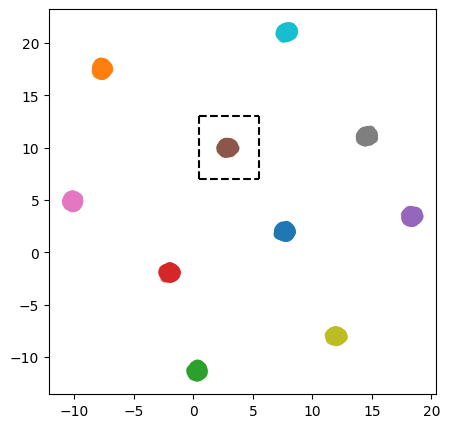

In [93]:
blob_2D = DV_blob.P.embedding_
cmap = 'tab10'
# blob_c = cm.tab10(blob30_y/9)
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(blob_2D[:,0], blob_2D[:,1], marker='o', c=blob30_y, cmap=cmap, alpha=0.5)

x_min, x_max = [0.5, 5.5]
y_min, y_max = [7, 13]

# plot the rectangular
plt.plot([x_min, x_min], [y_min, y_max], 'k--')
plt.plot([x_max, x_max], [y_min, y_max], 'k--')
plt.plot([x_min, x_max], [y_min, y_min], 'k--')
plt.plot([x_min, x_max], [y_max, y_max], 'k--')
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))
XY_blob = np.c_[xx.ravel(), yy.ravel()]

In [92]:


print(XY_blob.shape)
# ax.plot(XY_blob[:,0], XY_blob[:,1], 'k.', alpha=0.1)
# fig

blob_inv = DV_blob.inverse_transform(XY_blob)

print('computing LID')
eigen_list, lid_lsit = get_eigen_general(blob_inv)


(250000, 2)


In [58]:
# save the data
# make dir
if not os.path.exists('./local'):
    os.makedirs('./local')
np.save('.\local\blob30_eigen_id.npy', blob_inv)

In [3]:
blob_local = np.load('.\local\blob30_eigen_id.npy', allow_pickle=True)
lid_lsit = blob_local[''
eigen_list = blob_local[0]

blob_box = lid_lsit.reshape((500,500))
# flip the
# blob_box = np.flip(blob_box, axis=0)

# img = ax.imshow(blob_box, cmap='jet', alpha=0.9, extent=[x_min, x_max, y_min, y_max])
# blob_box_mean = np.mean(blob_box)
# ax.text(0.5, 12, f'LID={blob_box_mean:.2f}', fontsize=15, )
# # cbar
# cbar = fig.colorbar(img, ax=ax)
cnt = plt.contourf(xx, yy, blob_box, cmap='jet', alpha=0.9, levels=[0.5, 1.5, 2.5, 3.5, 4.5])
blob_box_mean = np.mean(blob_box)
plt.text(0.63, 0.13, f'{blob_box_mean:.2f}', fontsize=13, transform=plt.gcf().transFigure)
plt.colorbar(cnt, ticks=[1, 2, 3, 4], pad=0.02)

fig = plt.gcf()
fig.set_size_inches(3.5,3)

plt.xticks([])
plt.yticks([])

# set aspect ratio
# plt.gca().set_aspect('equal')

# plt.savefig('./figures/blob30_local.pdf', bbox_inches='tight', pad_inches=0.01)
# plt.savefig('../paper/PAPER_intrinsic_dim/figures//blob30_local.pdf', bbox_inches='tight', pad_inches=0.01)


ValueError: cannot reshape array of size 30 into shape (500,500)

(250000,)


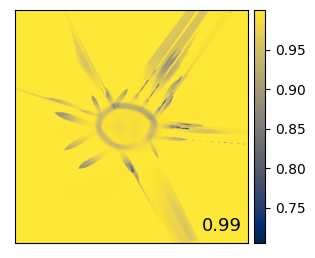

In [193]:

percent_list = np.sum(eigen_list[:, :2], axis=1)
print(percent_list.shape)
percent_list = percent_list.reshape(blob_box.shape)
# flip the
blob_box = np.flip(blob_box, axis=0)
perc_blob = plt.imshow(percent_list, cmap='cividis', alpha=1,)
plt.colorbar(perc_blob, pad=0.02)
plt.xticks([])
plt.yticks([])
mean_perc = np.mean(percent_list)
plt.text(0.63, 0.12, f'{mean_perc:.2f}', fontsize=13, transform=plt.gcf().transFigure)

fig = plt.gcf()
fig.set_size_inches(3.3,2.68)

# set aspect ratio
# plt.gca().set_aspect('equal')

plt.tight_layout()

## force the aspect ratio
# plt.gca().set_aspect('equal', adjustable='box')
plt.savefig('./figures/blob30_local_perc.pdf', bbox_inches='tight', pad_inches=0.01)
plt.savefig('../paper/PAPER_intrinsic_dim/figures/blob30_local_perc.pdf', bbox_inches='tight', pad_inches=0.01)

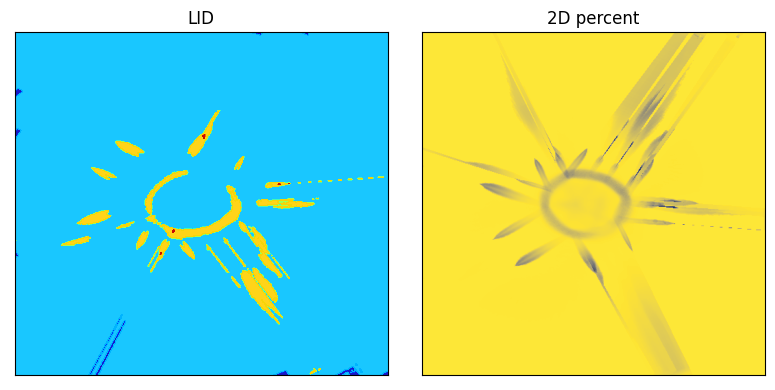

In [175]:
fig_blbo, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.contourf(blob_box, cmap='jet', alpha=0.9, )
ax1.set_title('LID')
ax1.set_xticks([])
ax1.set_yticks([])
# cbar
cbar = fig.colorbar(img, ax=ax)

ax2.imshow(percent_list, cmap='cividis', alpha=1,)
ax2.set_title('2D percent')
ax2.set_xticks([])
ax2.set_yticks([])
fig_blbo.tight_layout()
# plt.savefig('./figures/blob30_local.pdf', bbox_inches='tight', pad_inches=0.01)


## HAR

In [9]:
har = datasets_real['har']
har_X = har[0]
har_y = har[2]

clf_har = LogisticRegression(max_iter=1000, random_state=420)
DV_har = projectors['DeepView']

In [10]:
clf_har.fit(har_X, har_y)
DV_har.fit(har_X, har_y, clf=clf_har, y=har_y)

100%|██████████| 5000/5000 [16:03<00:00,  5.19it/s] 


updating matrices
(0,) (5000, 5000)
discr 0.09462857246398926
(0,) (5000, 5000)
fitting mapper
transforming
fitting inverse
done
fitting time:  1257.7667243480682


1257.7667243480682

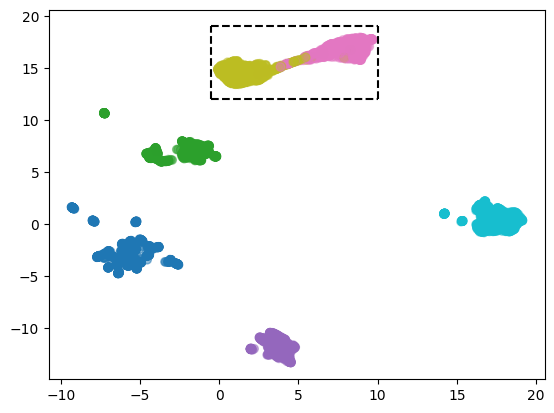

In [156]:
har_2D = DV_har.P.embedding_
cmap = 'tab10'
# blob_c = cm.tab10(blob30_y/9)

plt.scatter(har_2D[:,0], har_2D[:,1], marker='o', c=har_y, cmap=cmap, alpha=0.5)

x_min, x_max = [-0.5, 10]
y_min, y_max = [12, 19]

# plot the rectangular
plt.plot([x_min, x_min], [y_min, y_max], 'k--')
plt.plot([x_max, x_max], [y_min, y_max], 'k--')
plt.plot([x_min, x_max], [y_min, y_min], 'k--')
plt.plot([x_min, x_max], [y_max, y_max], 'k--')

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000), np.linspace(y_min, y_max, 500))
XY_har = np.c_[xx.ravel(), yy.ravel()]

In [62]:


print(XY_har.shape)

har_inv = DV_har.inverse_transform(XY_har)

print('computing LID')
har_eigen_list, har_lid_lsit = get_eigen_general(har_inv)
# save the data

np.save('.\local\har_eigen_id.npy', har_inv)

(500000, 2)
computing LID


100%|██████████| 500000/500000 [4:55:09<00:00, 28.23it/s]   


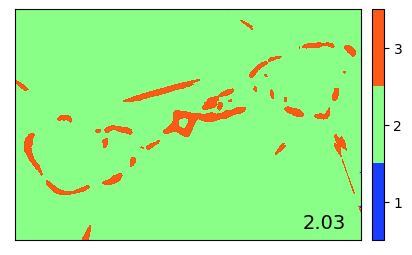

In [186]:
har_eigen_list, har_lid_lsit = np.load('.\local\har_eigen_id.npy', allow_pickle=True)

har_box = har_lid_lsit.reshape((1000,500))
# flip the

har_box_img = np.flip(har_box, axis=0)

# img = plt.imshow(har_box, cmap='jet', alpha=0.9, extent=[x_min, x_max, y_min, y_max])
# har_box_mean = np.mean(har_box)
# plt.text(0.5, 12, f'LID={har_box_mean:.2f}', fontsize=15, )
# # cbar
# cbar = plt.colorbar(img)
cnt = plt.contourf(xx, yy, har_box, cmap='jet', alpha=0.9, levels=[0.5,1.5,2.5,3.5], )
# h_img = plt.imshow(har_box, cmap='jet', alpha=0.9, extent=[x_min, x_max, y_min, y_max] )
har_box_mean = np.mean(har_box)
# set text , dont use absolute location
plt.text(0.83, 0.05, f'{har_box_mean:.2f}', fontsize=14, transform=plt.gca().transAxes )

# cbar
cbar = plt.colorbar(cnt, ticks=[1,2,3,4], pad = 0.02)
# set the aspect ratio to be corresponding to the xlim and ylim
# set figure size
fig = plt.gcf()
fig.set_size_inches(7,3)

# set the absolute values of x and y to be the same
plt.gca().set_aspect('equal', adjustable='box')

# not show the ticks
plt.xticks([])
plt.yticks([])

plt.show()
# fig
# save the figure
fig.savefig('./figures/har_lid_loc.pdf', bbox_inches='tight')
fig.savefig('../paper/PAPER_intrinsic_dim//figures/har_lid_loc.pdf', bbox_inches='tight')

(500000,)


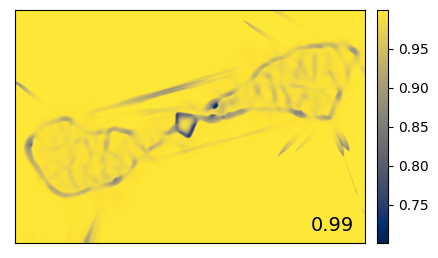

In [182]:

percent_list_har = np.sum(har_eigen_list[:, :2], axis=1)
print(percent_list_har.shape)
percent_list_har = percent_list_har.reshape(har_box.shape)
# flip the
percent_list_har = np.flip(percent_list_har, axis=0)
perc_har = plt.imshow(percent_list_har, cmap='cividis', alpha=1, extent=[x_min, x_max, y_min, y_max])
plt.colorbar(perc_har, pad=0.02)
plt.xticks([])
plt.yticks([])
mean_perc = np.mean(percent_list_har)
plt.text(0.73, 0.12, f'{mean_perc:.2f}', fontsize=14, transform=plt.gcf().transFigure)

fig = plt.gcf()
fig.set_size_inches(6.4,2.68)

# set aspect ratio
plt.gca().set_aspect('equal')

plt.tight_layout()

# save the figure
fig.savefig('./figures/har_perc_loc.pdf', bbox_inches='tight')
fig.savefig('../paper/PAPER_intrinsic_dim//figures/har_perc_loc.pdf', bbox_inches='tight')
